## Importing Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',None)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error
from warnings import filterwarnings
filterwarnings('ignore')

## Data PreProcessing

In [15]:
df = pd.read_csv('kc_house_data.csv')
df = df.drop('id',axis=True)
df['date'] = df['date'].apply(lambda x: x[0:4])
df = df.rename(columns={'date':'yr_sale'})
df['yr_sale'] = pd.to_numeric(df['yr_sale'])
df['age'] = df['yr_sale'] - df['yr_built'] # age of building when the houses were sold

def renovate(x,y):
    if x == 0: # age of renovation when house was sold
        return 0
    else:
        return y-x
    
def apply_renovation_function(x):
    return renovate(x['yr_renovated'],x['yr_sale'])

df['age_renovation'] = df.apply(apply_renovation_function,axis=1)

In [21]:
target = 'price' # Target Variable

## Correlation function

In [82]:
def remove_collinear_features(df_model, target_var, threshold, verbose):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold and which have the least correlation with the target (dependent) variable. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        df_model: features dataframe
        target_var: target (dependent) variable
        threshold: features with correlations greater than this value are removed
        verbose: set to "True" for the log printing

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = df_model.drop(target_var, 1).corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []
    dropped_feature = ""

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1): 
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                if verbose:
                    print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                col_value_corr = df_model[col.values[0]].corr(df_model[target_var])
                row_value_corr = df_model[row.values[0]].corr(df_model[target_var])
                if verbose:
                    print("{}: {}".format(col.values[0], np.round(col_value_corr, 3)))
                    print("{}: {}".format(row.values[0], np.round(row_value_corr, 3)))
                if col_value_corr < row_value_corr:
                    drop_cols.append(col.values[0])
                    dropped_feature = "dropped: " + col.values[0]
                else:
                    drop_cols.append(row.values[0])
                    dropped_feature = "dropped: " + row.values[0]
                if verbose:
                    print(dropped_feature)
                    print("-----------------------------------------------------------------------------")

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    df_model = df_model.drop(columns=drops)

    print("dropped columns: ")
    print(list(drops))
    print("-----------------------------------------------------------------------------")
    print("used columns: ")
    print(df_model.columns.tolist())

    return df_model

In [85]:
def correlation_overview(df):
    
    print(f"Pearson Correlation of features with target variable : \n{df.corr()[target].sort_values(ascending=False)[1:]}\n")
    # Features which have correlation greater than 0.7
    
    remove_collinear_features(df,target,0.7,True)
    
    
    features = list(df.columns)

    mask = np.zeros_like(df[features].corr(), dtype=np.bool) 
    mask[np.triu_indices_from(mask)] = True 

    f, ax = plt.subplots(figsize=(16, 12))
    plt.title('Pearson Correlation Matrix',fontsize=25)

    sns.heatmap(df[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

Pearson Correlation of features with target variable : 
sqft_living       0.702035
grade             0.667434
sqft_above        0.605567
sqft_living15     0.585379
bathrooms         0.525138
view              0.397293
sqft_basement     0.323816
bedrooms          0.308350
lat               0.307003
waterfront        0.266369
floors            0.256794
yr_renovated      0.126434
sqft_lot          0.089661
sqft_lot15        0.082447
age_renovation    0.067177
yr_built          0.054012
condition         0.036362
long              0.021626
yr_sale           0.003576
zipcode          -0.053203
age              -0.053951
Name: price, dtype: float64

sqft_living | bathrooms | 0.75
sqft_living: 0.702
bathrooms: 0.525
dropped: bathrooms
-----------------------------------------------------------------------------
grade | sqft_living | 0.76
grade: 0.667
sqft_living: 0.702
dropped: grade
-----------------------------------------------------------------------------
sqft_above | sqft_living | 0.88


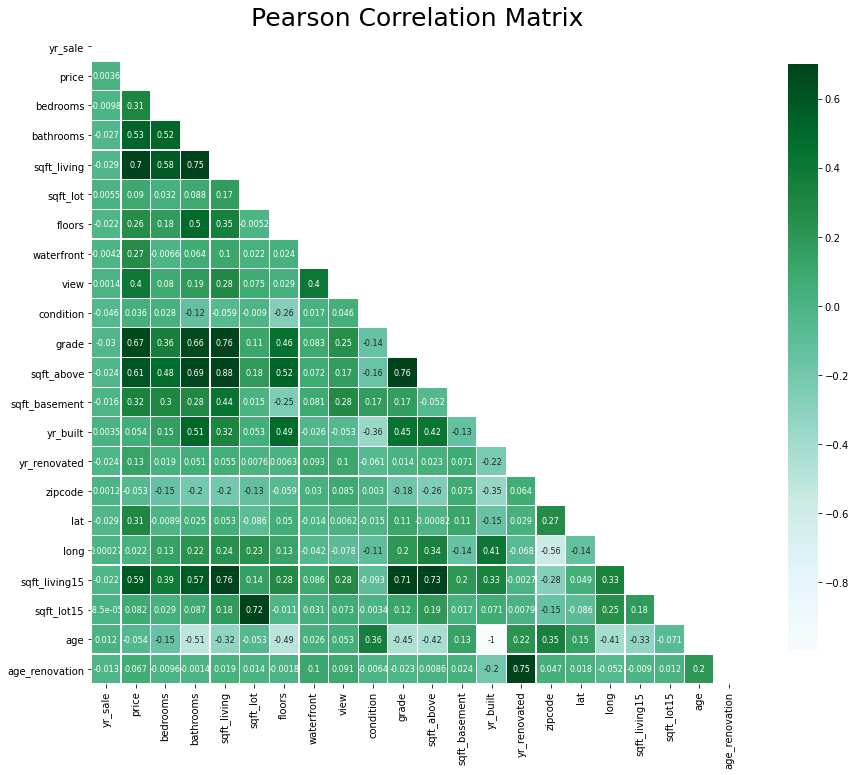

In [86]:
correlation_overview(df)

In [150]:
new_df = remove_collinear_features(df,target,0.7,False)

dropped columns: 
['sqft_above', 'sqft_living15', 'age_renovation', 'bathrooms', 'sqft_lot15', 'grade', 'age']
-----------------------------------------------------------------------------
used columns: 
['yr_sale', 'price', 'bedrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long']


## Simple Linear Regression Function

In [89]:
df

,yr_sale,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,age,age_renovation
0,2014,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,59,0.0
1,2014,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,63,23.0
2,2015,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,82,0.0
3,2014,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,49,0.0
4,2015,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,28,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,2014,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,5,0.0
21609,2015,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,1,0.0
21610,2014,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,5,0.0
21611,2015,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,11,0.0


In [116]:
def simple_linear_regression_all_variables(df,target):
    
    eval_lr = pd.DataFrame({'X-Variable':[],'MAE':[],'MAPE':[],'RMSE':[]})
    cols = list(df.drop(target,axis=1).columns)
    train_data,test_data = train_test_split(df,train_size=0.8,random_state=0)
    
    for i in range(len(cols)):
    
        # train-test-split
        x_train = np.array(train_data[cols[i]]).reshape(-1,1)
        y_train = np.array(train_data[target])
        x_test = np.array(test_data[cols[i]]).reshape(-1,1)
        y_test = np.array(test_data[target])

        # model fitting and metrics evaluation
        model = LinearRegression()
        model.fit(x_train,y_train)
        preds = model.predict(x_test)
        mae = mean_absolute_error(y_test,preds)
        mape = np.average((mae/y_test)*100)
        rmse = np.sqrt(mean_squared_error(y_test,preds))
        eval_lr.loc[eval_lr.shape[0]] = [cols[i],mae,mape,rmse]
        
        '''
        # PLotting 
        plt.figure(figsize=(8,4))
        plt.scatter(x_test,y_test,s=5,color='red',label='Actual Prices',alpha=0.1)
        plt.plot(x_test,preds,label='Predictions')
        plt.xlabel(cols[i])
        plt.ylabel('Price in $100,000')
        plt.legend()
        '''
        
    return (eval_lr.sort_values(by='RMSE').reset_index(drop=True))

In [117]:
simple_linear_regression_all_variables(df,target)

,X-Variable,MAE,MAPE,RMSE
0,sqft_living,170780.926281,42.294141,248879.061242
1,grade,169549.187404,41.989099,250232.175311
2,sqft_above,188531.576156,46.690114,277267.311296
3,sqft_living15,182206.099173,45.123601,277691.539074
4,bathrooms,200962.958111,49.768764,293733.118692
5,view,215528.937293,53.376050,321552.306867
6,lat,208211.812783,51.563953,326127.149091
7,sqft_basement,221716.937179,54.908517,327497.850275
8,bedrooms,220904.682981,54.707361,330690.051756
9,floors,218948.430152,54.222892,332722.488659


## Multiple Linear Regression

In [139]:
def data_split(df,target,features):
    
    train_data, test_data = train_test_split(df,train_size=0.8,random_state=0)
    
    x_train = train_data[features]
    y_train = train_data[target]
    x_test = test_data[features]
    y_test = test_data[target]
    
    return x_train,y_train,x_test,y_test

In [140]:
def multiple_linear_regression(df,target,features):
    
    nof = len(features)
    
    x_train,y_train,x_test,y_test = data_split(df,target,features)
    
    model = LinearRegression()
    model.fit(x_train,y_train)
    preds = model.predict(x_test)
    
    mae = mean_absolute_error(y_test,preds)
    mape = np.average((mae/y_test)*100)
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    
    print(f"Final Model with {nof} features : \nMean Absolute Error : {mae}\nMean Absolute Percentage Error : {mape}\nRoot Mean Squared Error : {rmse}")
    

In [144]:
def RFE_(df,target):
    
    # Determine the optimal number of features to use 
    
    nof_list = np.arange(1,df.drop('price',axis=1).shape[1]+1)
    high_score = 0
    nof = 0
    score_list = []
    df_features = df.drop(target,1).columns
    
    x_train,y_train,x_test,y_test = data_split(df,target,df_features) 
    
    for n in range(len(nof_list)):
     

        model = LinearRegression()
        rfe = RFE(model,n_features_to_select=nof_list[n])
        rfe = rfe.fit(x_train,y_train)

        X_rfe = x_train[x_train.columns[rfe.support_]] # features selected through RFE - new training set for particular features
        x_test_rfe = x_test[x_test.columns[rfe.support_]] # new test data with particular features

        model.fit(X_rfe,y_train)
        score = model.score(x_test_rfe,y_test)
        score_list.append(score)
        if (score>high_score):
            high_score = score
            nof = nof_list[n]
            
    ## Final RFE Model
    
    model = LinearRegression()
    rfe = RFE(model,n_features_to_select=nof)
    rfe = rfe.fit(x_train,y_train)
    
    print("Optimum number of features: %d" %nof)        
    temp = pd.Series(rfe.support_,index=x_train.columns)
    selected_features_rfe = temp[temp==True].index
    print(f"The Selected Features are : {list(selected_features_rfe)}")    
    print("Score with %d features: %f" % (nof, high_score))
    return selected_features_rfe

In [145]:
def RFE_regression(df,traget):
    
    features_rfe = RFE_(df,target) # Get the final variables from RFE
    multiple_linear_regression(df,target,features_rfe) # Run multiple Linear Regression with final variables

In [146]:
RFE_regression(df,target)

Optimum number of features: 18
The Selected Features are : ['yr_sale', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'age', 'age_renovation']
Score with 18 features: 0.697490
Final Model with 18 features : 
Mean Absolute Error : 121076.58034545877
Mean Absolute Percentage Error : 29.984788292609558
Root Mean Squared Error : 189672.8566437271
